# Import Modules

In [3]:
import pandas as pd
import numpy as np
import requests
import json
import re
import seaborn as sns
import time
from scipy.stats import norm
from matplotlib import pyplot as plt
import random
import datetime
from fund_analysis import *

# Import Data

In [4]:
start = pd.to_datetime('01/01/1988')
end = pd.to_datetime('04/16/2018')

In [5]:
# get CRSP database data
data = pd.read_csv('CRSP.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,12,49,50,51,62,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# get S&P 500 data
sp_data = get_yahoo_prices('^GSPC', start, end)

In [7]:
sp_data = sp_data.reset_index()

In [8]:
sp_data = sp_data[['date', 'adjclose']]

In [9]:
# get active and passive mutual fund net asset values
active_price = pd.read_csv('active_price_data.csv')
passive_price = pd.read_csv('passive_price_data.csv')

# Cleaning/Preparation

### CRSP Data

In [10]:
data.shape

(550596, 73)

In [11]:
data.columns

Index(['summary_period2', 'crsp_fundno', 'caldt', 'nav_latest',
       'nav_latest_dt', 'tna_latest', 'tna_latest_dt', 'yield', 'div_ytd',
       'cap_gains_ytd', 'nav_52w_h', 'nav_52w_h_dt', 'nav_52w_l',
       'nav_52w_l_dt', 'unrealized_app_dep', 'unrealized_app_dt', 'asset_dt',
       'per_com', 'per_pref', 'per_conv', 'per_corp', 'per_muni', 'per_govt',
       'per_oth', 'per_cash', 'per_bond', 'per_abs', 'per_mbs', 'per_eq_oth',
       'per_fi_oth', 'maturity', 'maturity_dt', 'cusip8', 'crsp_portno',
       'crsp_cl_grp', 'fund_name', 'ticker', 'ncusip', 'mgmt_name', 'mgmt_cd',
       'mgr_name', 'mgr_dt', 'adv_name', 'open_to_inv', 'retail_fund',
       'inst_fund', 'm_fund', 'index_fund_flag', 'vau_fund', 'et_flag',
       'delist_cd', 'first_offer_dt', 'end_dt', 'dead_flag', 'merge_fundno',
       'actual_12b1', 'max_12b1', 'exp_ratio', 'mgmt_fee', 'turn_ratio',
       'fiscal_yearend', 'crsp_obj_cd', 'si_obj_cd', 'accrual_fund',
       'sales_restrict', 'wbrger_obj_cd', 'poli

In [12]:
df = pd.DataFrame({'Fund Name' : data['fund_name'], 'Fund Ticker' : data['ticker'], 
                   'Open to Investors' : data['open_to_inv'], 'Expense Ratio' : data['exp_ratio'],
                  'Management Fee' : data['mgmt_fee'], 'Turnover Ratio' : data['turn_ratio']})

In [13]:
df.isnull().sum()

Expense Ratio         77314
Fund Name              7823
Fund Ticker           86503
Management Fee       144968
Open to Investors     81168
Turnover Ratio        77314
dtype: int64

In [14]:
df.dropna(inplace = True)

In [15]:
df['Turnover Ratio'].describe()

count    371785.000000
mean         -5.379646
std         182.354466
min         -99.000000
25%           0.210000
50%           0.490000
75%           0.990000
max      110120.080000
Name: Turnover Ratio, dtype: float64

In [16]:
# classify mutual funds as active or passive

df['Active or Passive'] = df['Expense Ratio'].apply(managed)
df['Active or Passive'] = df['Turnover Ratio'].apply(managed_turn)

In [17]:
df = df[df['Open to Investors'] == 'Y']

In [18]:
df = df[df['Management Fee'] > 0]

In [19]:
df = df[df['Expense Ratio'] > 0]

In [20]:
df.drop_duplicates(subset = ['Fund Ticker'], inplace = True)

In [21]:
df.shape

(39653, 7)

In [22]:
df['Active or Passive'].value_counts()

active     30680
passive     8973
Name: Active or Passive, dtype: int64

In [23]:
df_active = df[df['Active or Passive'] == 'active']
df_passive = df[df['Active or Passive'] != 'active']

### Active/Passive Price Data

In [24]:
active_price = active_price.iloc[:, 1:]
passive_price = passive_price.iloc[:, 1:]

In [25]:
active_price.set_index('date', inplace= True)
passive_price.set_index('date', inplace= True)

In [26]:
active_price.dropna(thresh = 1, inplace= True)
passive_price.dropna(thresh = 1, inplace= True)

In [27]:
sp_data = sp_data.set_index('date')

# Analysis Code (THE RESULTS ARE IN THE ADDITIONAL INSIGHTS SECTION)

### Calculating alpha for our sample dataset

In [28]:
sp_rets = pd.DataFrame(sp_data['adjclose'].pct_change())
active_rets = active_price.pct_change()
passive_rets = passive_price.pct_change()

In [29]:
active_rets['sp_data'] = sp_rets['adjclose']
passive_rets['sp_data'] = sp_rets['adjclose']

### subtracting S&P 500 returns from mutual fund returns

In [30]:
for col in active_rets.columns:
    try:
        active_rets[col] = active_rets[col] - active_rets['sp_data']    
    except:
        active_rets.drop(col, inplace = True)

In [31]:
for col in passive_rets.columns:
    try:
        passive_rets[col] = passive_rets[col] - passive_rets['sp_data']    
    except:
        passive_rets.drop(col, inplace = True)

In [32]:
active_rets.drop('sp_data', axis = 1, inplace = True)
passive_rets.drop('sp_data', axis = 1, inplace = True)

In [33]:
active_rets['average'] = active_rets.mean(axis = 1)
passive_rets['average'] = passive_rets.mean(axis = 1)


In [34]:
sp_std = sp_rets.rolling(252).std()
sp_rets = sp_rets.rolling(252).mean()

act_std = active_rets['average'].rolling(252).std()
act_rets = active_rets['average'].rolling(252).mean()

pas_std = passive_rets['average'].rolling(252).std()
pas_rets = passive_rets['average'].rolling(252).mean()

In [35]:
act_rets.dropna(how = 'all', inplace= True)

In [36]:
pas_rets.dropna(how = 'all', inplace= True)

In [37]:
act_rets_all = active_rets.rolling(252).mean()
pas_rets_all = passive_rets.rolling(252).mean()

In [38]:
act_rets*= 1000
pas_rets*= 1000
sp_rets['adjclose']*= 1000

### Number of Active vs Passive Funds

In [39]:
active = len(df_passive)
passive = len(df_active)

total = active + passive
act = round(100*(active/total),2)
pas = round(100*(passive/total),2)

### Management fees - Active vs Passive Funds

In [40]:
avg_active = round(df_active['Management Fee'].mean(),3)
avg_passive = round(df_passive['Management Fee'].mean(),3)


### Expense Ratio - Active vs Passive

In [41]:
avg_active_exp = round(df_active['Expense Ratio'].mean(),3)
avg_passive_exp = round(df_passive['Expense Ratio'].mean(),3)

### Top Active Mutual Funds

In [42]:
r = active_rets.drop('average', axis = 1).mean(axis = 0)
r = r.nlargest(10)
r *= 100

### Top Passive Mutual Funds

In [43]:
g = passive_rets.drop('average', axis = 1).mean(axis = 0)
g = g.nlargest(10)
g *= 100

# Visualization

In [44]:
active_mgmt = df_active['Management Fee']
pass_mgmt = df_passive['Management Fee']
active_exp = df_active['Expense Ratio']
pass_exp = df_passive['Expense Ratio']

In [45]:
df_active.loc[:,'Expense Ratio'] *= 100
df_passive.loc[:,'Expense Ratio'] *= 100

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Distribution of Fund Management Fee's

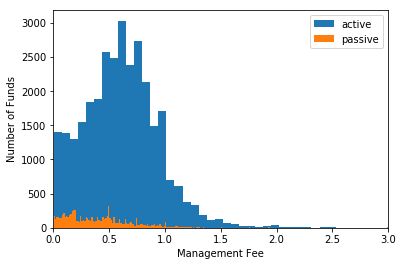

In [46]:
plt.hist(active_mgmt, bins = 500, label='active')
plt.hist(pass_mgmt, bins = 500, label='passive')
plt.xlabel('Management Fee')
plt.ylabel('Number of Funds')
plt.legend(loc='upper right')
plt.xlim(0,3)
plt.show()


### Distribution of Fund Expense Ratio's

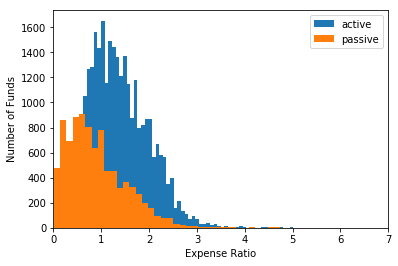

In [47]:
plt.hist(active_exp, bins = 700, label='active')
plt.hist(pass_exp, bins = 50, label='passive')
plt.xlabel('Expense Ratio')
plt.ylabel('Number of Funds')
plt.legend(loc='upper right')
plt.xlim(0,7)
plt.show()

### Active vs Passive Mutual Fund  Over Time

In [48]:
act_rets.index = pd.to_datetime(act_rets.index)
pas_rets.index = pd.to_datetime(pas_rets.index)

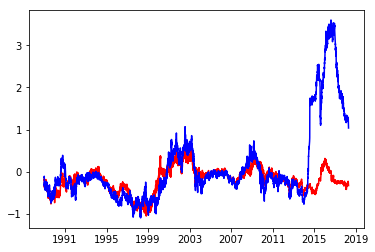

In [57]:
# Red line represnts alpha for active funds from our sample
# Blue line represnts alpha for passive funds from our sample
plt.plot(act_rets, color = 'r')
plt.plot(pas_rets, color = 'b')

# Conclusion

As we can see in the figure above, passive mutual funds have higher alphas when compared to active mutual funds. An interesting trend shown in the chart above is that the alpha of passive funds breakout from 2014 onwards. This can be due to a bullish market that started during that period and massive inflows of capital in passive strategies. Please note that the result of this chart can change as this is plotted using a random sample selected from the active and passive fund database we created earlier. 

Our findings show that actively managed funds do not consistently beat the market. They give similar nominal returns to passive funds. When we consider the fact that active funds have high management fees and expense ratios, the alpha of active funds on average is negative. 

# Additional Insights

In [50]:
# NOTE : THIS IS FOR THE WHOLE DATASET

print('Average management fee for actively managed funds: {}%'.format(avg_active))
print('Average management fee for passively managed funds: {}%'.format(avg_passive))

Average management fee for actively managed funds: 0.611%
Average management fee for passively managed funds: 0.414%


In [51]:
# NOTE : THIS IS FOR THE WHOLE DATASET

print('There are {} ({}%) actively managed mutual funds'.format(active, act))
print('There are {} ({}%) passively managed mutual funds'.format(passive, pas))

There are 8973 (22.63%) actively managed mutual funds
There are 30680 (77.37%) passively managed mutual funds


In [52]:
# NOTE : THIS IS FOR THE WHOLE DATASET

print('Average expense ratio for actively managed funds: {}%'.format(avg_active_exp))
print('Average expense ratio for passively managed funds: {}%'.format(avg_passive_exp))

Average expense ratio for actively managed funds: 0.013%
Average expense ratio for passively managed funds: 0.009%


In [53]:
print('The top 10 active mutual funds and their average annual returns are:')
print(r)

The top 10 active mutual funds and their average annual returns are:
UBIO     4.142635
FVC      0.791529
PSDKX    0.621025
PFAPX    0.611398
PFATX    0.456357
PQICX    0.182619
CSQIX    0.168508
TNA      0.140785
BEMSX    0.131291
SMAVX    0.091094
dtype: float64


In [54]:
# NOTE: There are data quality issues with yahoo finance
# ex. yahoo finance shows that the ticker 'RSW' which we classified as passive has no data on it
# But if we look at the data we have on it:

passive_price['RSW'].dropna()

# We see that yahoo finance has data for two days

date
2016-01-27    17.73
2016-07-26    24.07
Name: RSW, dtype: float64

In [55]:
print('The top 10 passive mutual funds and their average annual returns are:')
print(g)

The top 10 passive mutual funds and their average annual returns are:
RSW      35.726325
SKK       9.272849
UWPSX     9.080606
UUPSX     5.558224
IFV       5.186953
AFBSX     5.016365
GMRPX     3.957304
GDXX      3.075339
RYCBX     2.472081
IPK       2.416357
dtype: float64
